# OCR Travelling Place (Simple Version)
 
Name: Anthony Kevin Oktavius

Library Import

In [ ]:
# ! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
! pip install pytorch-lightning --quiet
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 49.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torchmetrics
import torch.nn.functional as F
import PIL
import pytorch_lightning as pl
import imutils
from sklearn.metrics import confusion_matrix, roc_curve

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from google.colab.patches import cv2_imshow
from pytorch_lightning.loggers import TensorBoardLogger
from imutils.contours import sort_contours

print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1789678837075111530
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13912375296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 85403557541342419
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


Set Matplotlib Figure to SVG.

In [ ]:
display.set_matplotlib_formats('svg')

Set CPU or GPU on Google Colab

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5672382930427343820
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 13912375296
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6808605889236640656
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Initialize Plot Images in Grid Function, which displays the grid of images.

In [ ]:
def plot_images_in_grid(title, images, labels, figsize = (5, 5), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = (5, 5))
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_grid(images_in_batch):
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  sample_image_batch, sample_labels_batch = next(iter_loader)

  plt.title(f"{title} Dataset: {sample_image_batch.shape}")
  visualize_grid(sample_image_batch)

def debug_dataloader(data_loader, title, expected_batch_size):
   print(f"Debugging {title}...")
   iter_loader = iter(data_loader)
   total_exact_same_batches = 0
   different_batches = []
   print(list(data_loader))
  #  try:
  #   for sample_image_batch, sample_labels_batch in iter_loader:
  #     if sample_image_batch.numpy().shape[0] == total_exact_same_batches:
  #       total_exact_same_batches += 1
  #     else:
  #       different_batches.append(sample_image_batch.numpy().shape)
  #  except TypeError as e:
  #   print(e)
  #   print("Error on iter_loader:")
  #   print(sample_image_batch)
  #   print(sample_image_batch.dtype)

  #  print(f"Total Exact same batches: {total_exact_same_batches}")
  #  print(f"Total different batches: {len(different_batches)}")
  #  print(f"Different batches: {different_batches}")

Define our custom mapping from character to integers.

In [ ]:
digits_labels = "0123456789"
uppercase_letters_labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
lowercase_letters_labels = "abcdefghijklmnopqrstuvwxyz"
punctuation_labels = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""

full_labels = f"{digits_labels}{uppercase_letters_labels}{lowercase_letters_labels}{punctuation_labels}"

def change_character_to_integer(character):
  return int(full_labels.find(character))

## MNIST Data Preparation

Load letters dataset.



In [ ]:
emnist_trainset = torchvision.datasets.EMNIST('emnist', 
                                      split = 'byclass',
                                      train = True, 
                                      download = True,
                                      transform = mnist_train_transform)

emnist_valset = torchvision.datasets.EMNIST('emnist', 
                                    split = 'byclass',
                                     train = False,
                                     download = False,
                                     transform = mnist_validation_transform)

print(f"EMNIST train dataset: {emnist_trainset.data.shape}")
print(f"EMNIST test dataset: {emnist_valset.data.shape}")

EMNIST train dataset: torch.Size([697932, 28, 28])
EMNIST test dataset: torch.Size([116323, 28, 28])


In [ ]:
for data, label in zip(emnist_trainset.data, emnist_trainset.train_labels):
  print(data.shape)
  print(label.shape)
  print(data)
  print(label)
  break

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([28, 28])
torch.Size([])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,  22,  81, 125,  77,   0,   0,   0,   0],
        [  0,   0,   1,  19,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,  20, 159, 232, 249, 206,  10,   0,   0,   0],
        [ 

Visualize the Datasets

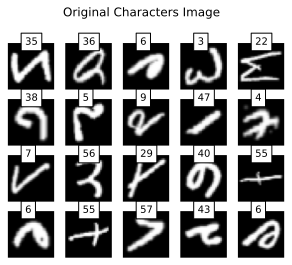

In [ ]:
MIN_INDEX_PLOT = 1
MAX_INDEX_PLOT = 20

plot_images_in_grid("Original Characters Image", emnist_trainset.data, emnist_trainset.train_labels.numpy())

Make Data Loaders based from these datasets.

In [ ]:
batch_size = 128

emnist_train_loader = torch.utils.data.DataLoader(
    emnist_trainset, 
    batch_size = batch_size, 
    shuffle = True
)

emnist_validation_loader = torch.utils.data.DataLoader(
    emnist_valset, 
    batch_size = batch_size, 
    shuffle = False
)

# To inspect the data loaders.
# debug_dataloader(emnist_train_loader, "EMNIST Train loader", batch_size)
# debug_dataloader(emnist_validation_loader, "EMNIST Validation loader", batch_size)

Visualize Data Augmentation Process.

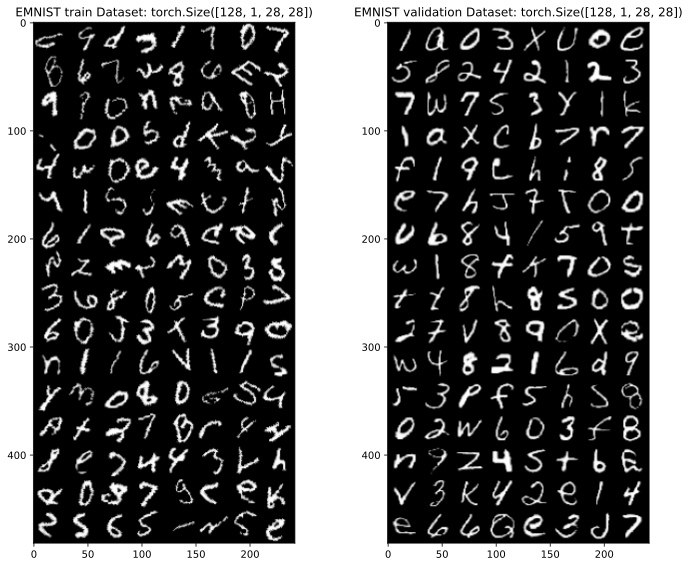

In [ ]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
visualize_dataloader(emnist_train_loader, "EMNIST train")

plt.subplot(1, 2, 2)
visualize_dataloader(emnist_validation_loader, "EMNIST validation")

plt.tight_layout()
plt.show()

Save EMNIST Data Loader for Future Use.

In [ ]:
# torch.save(emnist_trainset, "emnist_trainset.pth")
# torch.save(emnist_valset, "emnist_valset.pth")

Make a Function to resample the Image.

In [ ]:
def emnist_transform(image):
  rotated_image = TF.rotate(image, -90)
  flipped_image = TF.hflip(rotated_image)

  return flipped_image

Initialize Transform Compose Functions for Data Augmentation

In [ ]:
mnist_train_transform = transforms.Compose([
    transforms.Lambda(emnist_transform),
    transforms.RandomAffine(degrees = 10, translate = (0.1, 0.1), shear = 2),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )) # Scale to -1 to 1
])

mnist_validation_transform = transforms.Compose([
    transforms.Lambda(emnist_transform),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

## Computer Fonts (TMNIST) Data Preparation Dataset

In [ ]:
def tmnist_train_transform(image):
  random_rotation_range = random.randint(10, 30)
  added_dimension_image = image.unsqueeze(0)
  rotated_image = TF.rotate(added_dimension_image, random_rotation_range)
  normalized_image = TF.normalize(rotated_image, 0.5, 0.5)
  return normalized_image

def tmnist_validation_transform(image):
  added_dimension_image = image.unsqueeze(0)
  normalized_image = TF.normalize(added_dimension_image, 0.5, 0.5)
  return normalized_image

### Dataset Download

Download Computer Fonts Dataset

In [ ]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d nikbearbrown/tmnist-alphabet-94-characters

 97% 82.0M/84.7M [00:00<00:00, 109MB/s] 
100% 84.7M/84.7M [00:00<00:00, 93.5MB/s]


In [ ]:
! unzip tmnist-alphabet-94-characters.zip -d computer-fonts-mnist

Archive:  tmnist-alphabet-94-characters.zip
  inflating: computer-fonts-mnist/94_character_TMNIST.csv  


Make a copy of TMNIST file to drive.

In [ ]:
! cp -fr computer-fonts-mnist/94_character_TMNIST.csv "./drive/MyDrive/Dataset/Computer Fonts MNIST"

### Data Preparation

Load and Inspect TMNIST File

In [ ]:
tmnist_directory = "./computer-fonts-mnist"
tmnist_df = pd.read_csv(f"{tmnist_directory}/94_character_TMNIST.csv")
tmnist_df.head()

names labels    1    2    3    4    5    6    7    8  ...  \
0         Salsa-Regular      6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1  MouseMemoirs-Regular      D  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2     Creepster-Regular      f  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3     SeoulNamsan-Light      /  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4  HachiMaruPop-Regular      F  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   775  776  777  778  779  780  781  782  783  784  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 786 columns]

In [ ]:
tmnist_df.tail()

names labels    1    2    3    4    5    6  \
274088         BalooChettan2-Regular      6  0.0  0.0  0.0  0.0  0.0  0.0   
274089        Prompt-ExtraBoldItalic      <  0.0  0.0  0.0  0.0  0.0  0.0   
274090  FiraSansCondensed-ThinItalic      z  0.0  0.0  0.0  0.0  0.0  0.0   
274091                 GothicA1-Bold      ~  0.0  0.0  0.0  0.0  0.0  0.0   
274092                 Tuffy-Regular      I  0.0  0.0  0.0  0.0  0.0  0.0   

          7    8  ...  775  776  777  778  779  780  781  782  783  784  
274088  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
274089  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
274090  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
274091  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
274092  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 786 columns]

In [ ]:
print("Total nulls in TMNIST dataset:")
sum(tmnist_df.isnull().sum())

Total nulls in TMNIST dataset:


0

In [ ]:
tmnist_df_columns = tmnist_df.columns
print(f"TMNIST labels Columns: {tmnist_df_columns[1]}")
print(f"TMNIST Pixel Images Columns: {tmnist_df_columns[2:]}")

TMNIST labels Columns: labels
TMNIST Pixel Images Columns: Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '775', '776', '777', '778', '779', '780', '781', '782', '783', '784'],
      dtype='object', length=784)


In [ ]:
tmnist_labels = tmnist_df["labels"].to_numpy()
tmnist_labels = np.vectorize(change_character_to_integer)(tmnist_labels)
tmnist_pixel_images = tmnist_df[tmnist_df_columns[2:]].to_numpy()
tmnist_pixel_images = tmnist_pixel_images.reshape(-1, 28, 28)

print(tmnist_labels.shape)
print(tmnist_pixel_images.shape)

(274093,)
(274093, 28, 28)


Based on the activities above, let's Putting it all together in Dataset Class.

In [ ]:
tensor_tmnist_image = torch.from_numpy(tmnist_pixel_images)
tensor_tmnist_labels = torch.Tensor(tmnist_labels)

tensor_tmnist_image = tensor_tmnist_image.type(torch.FloatTensor)
tensor_tmnist_labels = tensor_tmnist_labels.type(torch.uint8)

print(tensor_tmnist_image.shape)
print(tensor_tmnist_labels.shape)
print(tensor_tmnist_labels)

torch.Size([274093, 28, 28])
torch.Size([274093])
tensor([ 6, 13, 41,  ..., 61, 93, 18], dtype=torch.uint8)


In [ ]:
tensor_tmnist_dataset = data_utils.TensorDataset(tensor_tmnist_image, tensor_tmnist_labels)

TRAIN_SIZE = 0.9
tmnist_train_size = int(TRAIN_SIZE * len(tensor_tmnist_dataset))
tmnist_test_size = len(tensor_tmnist_dataset) - tmnist_train_size

tmnist_train, tmnist_val = torch.utils.data.random_split(tensor_tmnist_dataset, [tmnist_train_size, tmnist_test_size])

Preprocess the dataset.

In [ ]:
tmnist_train_transform_lambda = transforms.Lambda(tmnist_train_transform)
tmnist_validation_transform_lambda = transforms.Lambda(tmnist_validation_transform)

# This class can be seen on: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class TMNISTDataset(Dataset):
  def __init__(self, subset, transform=None):
    self.subset = subset
    self.transform = transform
      
  def __getitem__(self, index):
    x, y = self.subset[index]
    if self.transform:
        x = self.transform(x)
    return x, y
      
  def __len__(self):
    return len(self.subset)

tmnist_train_dataset = TMNISTDataset(
    subset = tensor_tmnist_dataset,
    transform = tmnist_train_transform_lambda
)
tmnist_validation_dataset = TMNISTDataset(
    subset = tmnist_val, 
    transform = tmnist_validation_transform_lambda
)

In [ ]:
batch_size = 128

tmnist_train_loader = torch.utils.data.DataLoader(
    tmnist_train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
)

tmnist_validation_loader = torch.utils.data.DataLoader(
    tmnist_validation_dataset, 
    batch_size = batch_size, 
    shuffle = False
)

# debug_dataloader(tmnist_train_loader, "TMNIST Train loader", batch_size)
# debug_dataloader(tmnist_validation_loader, "TMNIST Validation loader", batch_size)

### ONLY RUN THIS IF YOU'D LIKE TO VISUALIZE THE DATASET.

Visualize the Dataset

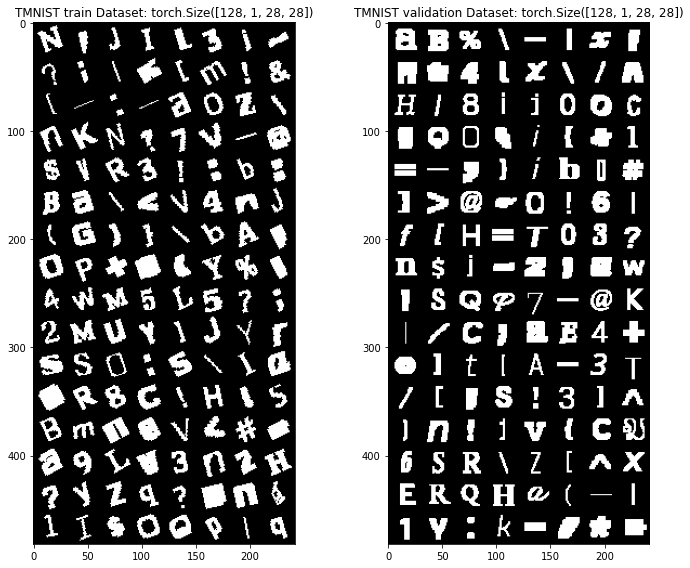

In [ ]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)

visualize_dataloader(tmnist_train_loader, "TMNIST train")

plt.subplot(1, 2, 2)
visualize_dataloader(tmnist_validation_loader, "TMNIST validation")

plt.tight_layout()
plt.show()

In [ ]:
debug_dataloader(tmnist_train_loader, "TMNIST Data Loader", batch_size)
debug_dataloader(tmnist_validation_loader, "TMNIST Data Loader", batch_size)

Save Pytorch Data Loader for Later Use, so we don't have to reload the dataset again and again.

In [ ]:
# torch.save(tmnist_train_loader, f"tmnist_train_loader.pth")
# torch.save(tmnist_validation_loader, f"tmnist_validation_loader.pth")

## Data Concatenation

Note that the steps above are used for individual data preprocesing and visualization to debug the dataset. Now, it's time for the real deal. Let's concatenate the datasets together so we can feed the data to the model, which will be trained.

Note that there are 2 datasets used for performing OCR project:

* EMNIST (For Handwritten Letter and Digits)
* TMNIST (For typography Letter and Digits)

Recheck the shape for each train and validation datasets. This is used to avoid errors happening during the concatenation process.

In [ ]:
print(f"TMNIST Total Train Dataset: {len(tmnist_train_dataset)}")
print(f"TMNIST Total Validation Dataset: {len(tmnist_validation_dataset)}")
print(f"EMNIST Total Train Dataset: {len(emnist_trainset)}")
print(f"EMNIST Total Validation Dataset: {len(emnist_valset)}")

TMNIST Total Train Dataset: 274093
TMNIST Total Validation Dataset: 54819
EMNIST Total Train Dataset: 697932
EMNIST Total Validation Dataset: 116323


It's time to concatenate the datasets! Make sure to check the size of the dataset first before proceeding!

In [ ]:
# emnist_train_data, emnist_train_labels = emnist_trainset.data.numpy(), emnist_trainset.train_labels.numpy()
# emnist_validation_data, emnist_validation_labels = emnist_valset.data.numpy(), emnist_valset.train_labels.numpy()

# tmnist_data, tmnist_labels = tmnist_pixel_images.squeeze(1), tmnist_labels

# print("EMNIST Shapes:")
# print(emnist_train_data.shape)
# print(emnist_train_labels.shape)
# print(emnist_validation_data.shape)
# print(emnist_validation_labels.shape)

# print()
# print("TMNIST Shapes:")
# print(tmnist_data.shape)
# print(tmnist_labels.shape)

In [ ]:
# data = np.vstack([emnist_train_data, emnist_validation_data, tmnist_data])
# labels = np.hstack([emnist_train_labels, emnist_validation_labels, tmnist_labels])

# print("Full dataset shape:")
# print(data.shape)
# print(labels.shape)

In [ ]:
full_train_dataset = torch.utils.data.ConcatDataset((tmnist_train_dataset, emnist_trainset))
full_validation_dataset = torch.utils.data.ConcatDataset((tmnist_validation_dataset, emnist_valset))

print(f"Full total train dataset: {len(full_train_dataset)}")
print(f"Full total validation dataset: {len(full_validation_dataset)}")

Full total train dataset: 972025
Full total validation dataset: 171142


Make Data Loaders

In [ ]:
batch_size = 250

full_train_data_loader = torch.utils.data.DataLoader(
    full_train_dataset,
    batch_size = batch_size, 
    shuffle = False,
    drop_last = True,
)

full_validation_data_loader = torch.utils.data.DataLoader(
    full_validation_dataset,
    batch_size = batch_size, 
    shuffle = False,
    drop_last = True
)

# while True:
#   try:
#     sample_image_batch, sample_labels_batch = next(train_iter_loader)
#   except TypeError as e:
#     print(sample_image_batch)
#     print(e)
#     break


# validation_iter_loader = iter(full_validation_data_loader)
# for sample_image_batch, sample_labels_batch in validation_iter_loader:
#   pass



# print("Safe to use.")

In [ ]:
# debug_dataloader(full_train_data_loader, "Full train data loader", 250)
# debug_dataloader(full_validation_data_loader, "Full validation data loader", 250)

Debugging Full validation data loader...


TypeError: ignored

Visualize the dataset

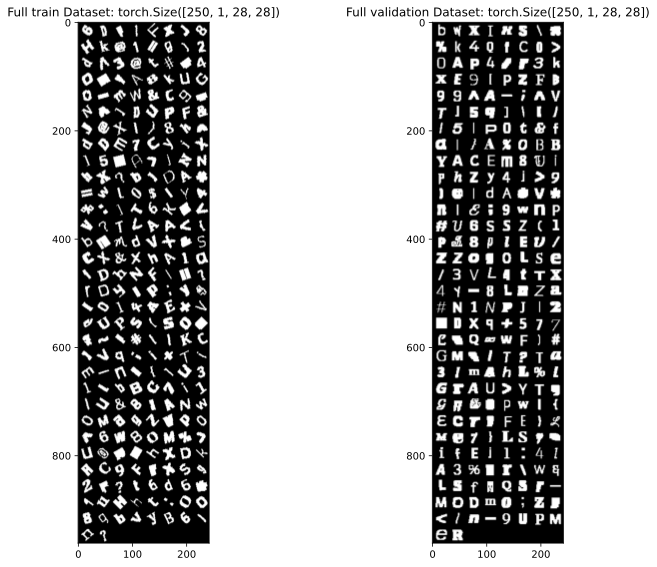

In [ ]:
plt.figure(figsize = (10, 8))

plt.subplot(1, 2, 1)
visualize_dataloader(full_train_data_loader, "Full train")

plt.subplot(1, 2, 2)
visualize_dataloader(full_validation_data_loader, "Full validation")

plt.tight_layout()
plt.show()

## Data Modelling

Count total number of classes after MNIST and TMNIST Concatenation.

In [ ]:
print(f"Number of Digits: {len(digits_labels)}")
print(f"Number of uppercase letters: {len(uppercase_letters_labels)}")
print(f"Number of lowercase letters: {len(lowercase_letters_labels)}")
print(f"Number of punctuations: {len(punctuation_labels)}")

len(full_labels)

Number of Digits: 10
Number of uppercase letters: 26
Number of lowercase letters: 26
Number of punctuations: 32


94

### With Default Pytorch Implementation

In [ ]:
class OCR_TMNIST_Model(nn.Module):
  def __init__(self):
    super().__init__()

    # We calculate this formula for padding.
    # NOTES: Filter_size = kernel_size
    # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

    # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
    # Output after conv1: [(28 - 3 + 2 (1) / 1) + 1] = 28
    # Output after MaxPool1 = 28 / 2 = 14
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1, bias = True), nn.ReLU(), nn.MaxPool2d(2,2))

    # To attain same padding: we use features of 
    # Padding: [(3 - 1) / 2] = 1
    # Output after conv2: [(14 - 3 + 2 (1) / 1) + 1] = 14
    # Output after MaxPool2: 14 / 2 = 7
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, bias = True), nn.ReLU(), nn.MaxPool2d(2,2))

    self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1, bias = True), nn.ReLU(), nn.MaxPool2d(2,2))

    # Flatten the layers.
    # 32 = number of filters
    # 7 = size of max pool 2 feature map output.
    self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(128*3*3,64), nn.ReLU(), nn.Linear(64,32), nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(32,16), nn.ReLU(), nn.Linear(16,8), nn.ReLU())
    self.fc3 = nn.Sequential(nn.Linear(8,94))

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

ocr_tmnist_model = OCR_TMNIST_Model()
ocr_tmnist_model.to(device)

OCR_TMNIST_Model(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)

In [ ]:
import torch.optim as optim

cross_entropy_loss_function = nn.CrossEntropyLoss()


# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
adam_optimizer = optim.SGD(ocr_tmnist_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 15

epochs_log = []
loss_log = []
accuracy_log = []

def validate_model(model, val_batches, device):
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_batches:
      data, labels = batch

      # Move the data to GPU.
      data = data.to(device)  
      labels = labels.to(device)

      # Perform feed forward to the model.
      outputs = model(data)

      # Get the prediction of each output. (Softmax)
      _, predicted = torch.max(outputs.data, 1)

      # Get the label size to total variable. 
      total += labels.size(0)

      # Keep a running total .
      correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def training_step(model, loss_function, optimizer, train_batch, device):
  data, labels = train_batch
  data = data.to(device)
  labels = labels.to(device)

  optimizer.zero_grad()

  outputs = model(data)
  loss = loss_function(outputs, labels)
  loss.backward()
  optimizer.step()

  return loss.item()

def train_model(epochs, model, train_loader, validation_loader, loss_function, optimizer, device, num_validation_per_steps = 200):
  print("Start training...")
  print(f"Train loader size: {len(train_loader)}")
  print(f"Validation loader size: {len(validation_loader)}")
  for epoch in range(epochs):
    current_loss = 0.0
    running_loss = 0.0
    for iteration, batch in enumerate(train_loader):
      # Perform training and get the current batch loss
      current_batch_loss = training_step(model, loss_function, optimizer, batch, device)
      # Add the current batch loss to running loss.
      running_loss += current_batch_loss

      # Validate every (n) steps, except at the very start of training.
      if iteration % num_validation_per_steps == num_validation_per_steps - 1:
        validation_accuracy = validate_model(model, validation_loader, device)

        training_loss = running_loss / num_validation_per_steps
        validation_accuracy = validation_accuracy
        running_loss = 0.0

        print(f"Epoch: [{epoch + 1}/{epochs}], at iteration {iteration}, Training Loss: {training_loss}, Validation Accuracy: {validation_accuracy}%")

train_model(
  epochs = 12,
  model = ocr_tmnist_model,
  train_loader = tmnist_train_loader,
  validation_loader = tmnist_validation_loader,
  optimizer = adam_optimizer,
  loss_function = cross_entropy_loss_function,
  device = device,
  num_validation_per_steps = 50
)

Start training...
Train loader size: 2142
Validation loader size: 215
Epoch: [1/12], at iteration 49, Training Loss: 4.543213748931885, Validation Accuracy: 0.9157241882524626%
Epoch: [1/12], at iteration 99, Training Loss: 4.4368902206420895, Validation Accuracy: 2.0576431959139%
Epoch: [1/12], at iteration 149, Training Loss: 4.368452281951904, Validation Accuracy: 2.790952207223641%


KeyboardInterrupt: ignored

In [ ]:
device_name = "gpu"

Save model for future use.

In [ ]:
def save_model(model, optimizer, filename = "model.pth.tar"):
  print("Saving model...")
  checkpoint = {
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict()
  }
  torch.save(checkpoint, filename)
  print("Finished saving model!")


directory_path = "./drive/MyDrive/Models"
save_model(ocr_tmnist_model, adam_optimizer, f"{directory_path}/model_{device_name}.pth.tar")

Reload the model

In [ ]:
def load_model(model, optimizer, filename = "model.pth.tar"):
  print("Loading model...")
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Finished loading model!")

  return model, optimizer

directory_path = "./drive/MyDrive/Models"
ocr_tmnist_model = OCR_TMNIST_Model()
ocr_tmnist_model, adam_optimizer = load_model(ocr_tmnist_model, adam_optimizer, f"{directory_path}/model_{device_name}.pth.tar")

Loading model...
Finished loading model!


####  WARNING: VISUALIZE THE MODEL CAN TAKE QUITE A LONG TIME, USE IT WHEN YOU'D LIKE TO DIG DEEPER ABOUT THE MODEL.

Visualize current model's weight by plotting. It's very fun! 

Model Weights:
conv1.0.weight: torch.Size([32, 1, 3, 3])
conv1.0.bias: torch.Size([32])
conv2.0.weight: torch.Size([64, 32, 3, 3])
conv2.0.bias: torch.Size([64])
conv3.0.weight: torch.Size([128, 64, 3, 3])
conv3.0.bias: torch.Size([128])
fc1.1.weight: torch.Size([64, 1152])
fc1.1.bias: torch.Size([64])
fc1.3.weight: torch.Size([32, 64])
fc1.3.bias: torch.Size([32])
fc2.0.weight: torch.Size([16, 32])
fc2.0.bias: torch.Size([16])
fc2.2.weight: torch.Size([8, 16])
fc2.2.bias: torch.Size([8])
fc3.0.weight: torch.Size([94, 8])
fc3.0.bias: torch.Size([94])


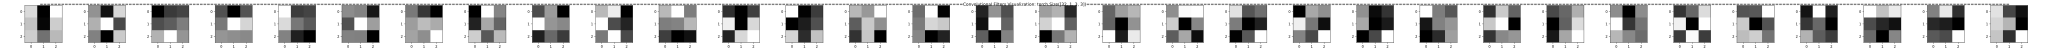

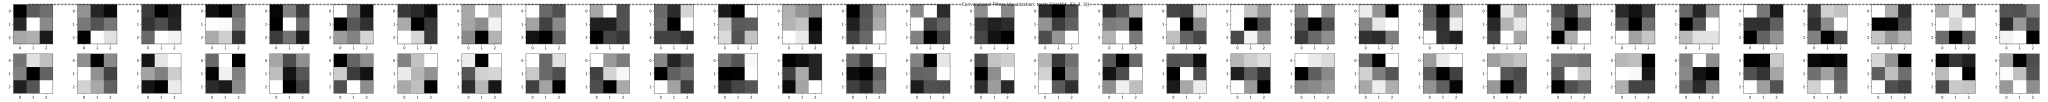

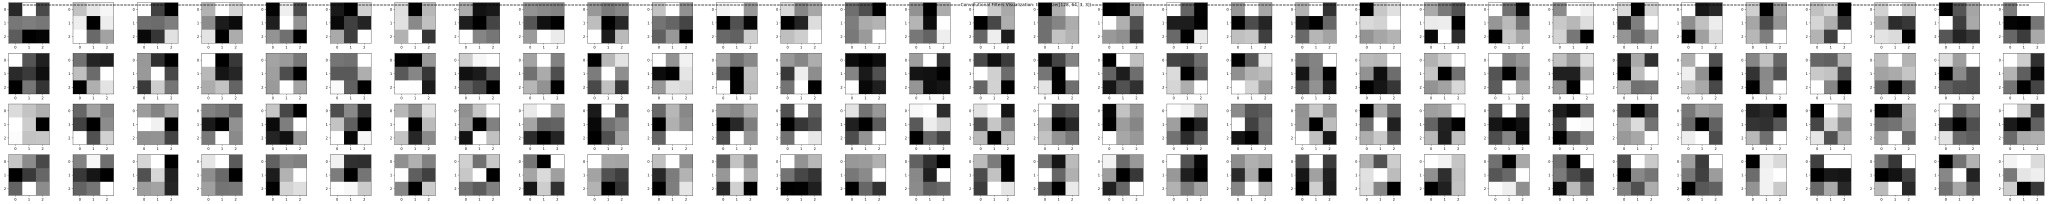

In [ ]:
def visualize_conv_weights(filters):
  number_of_filters = filters.shape[0]

  number_of_rows = math.ceil(number_of_filters / 32)
  number_of_columns = 32

  plt.figure(figsize = (80, number_of_rows * 2))
  border_in_string = "=" * 260
  plt.suptitle(f"{border_in_string}Convolutional Filters Visualization: {filters.shape}{border_in_string}")
  for index, filter in enumerate(filters):
    filter_weight = torch.sum(filter, dim = 0)
    
    plt.subplot(number_of_rows, number_of_columns, index + 1, label = f"Filter {index}")
    plt.imshow(filter_weight.cpu(), cmap = "gray")

  plt.tight_layout()
  plt.show()

def debug_model_weights(model_weights):
  print("Model Weights:")
  model_weight_keys = list(model_weights.keys())
  
  for weight_name in model_weights:
    print(f"{weight_name}: {model_weights[weight_name].shape}")

def visualize_conv_model_weights(model_weights):
  model_weight_keys = list(model_weights.keys())
  conv_weight_keys = [key for key in model_weight_keys if "conv" in key and "weight" in key]

  for conv_weight_key in conv_weight_keys:
    visualize_conv_weights(model_weights[conv_weight_key])

debug_model_weights(ocr_tmnist_model.state_dict())
visualize_conv_model_weights(ocr_tmnist_model.state_dict())

Visualize output features of each of the model. It's pretty fun as well!

Your previous sample data: torch.Size([1, 28, 28])
Your current sample data: torch.Size([1, 1, 28, 28])


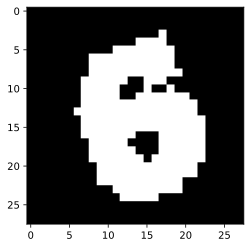

In [ ]:
def make_one_sample_data(tensor_dataset, data_index):
  sample_datum = tensor_dataset[data_index][0]
  print(f"Your previous sample data: {sample_datum.shape}")
  sample_datum = sample_datum.unsqueeze(0)
  print(f"Your current sample data: {sample_datum.shape}")
  return sample_datum

sample_datum = make_one_sample_data(tmnist_train_dataset, 0)
visualize_grid(sample_datum)

Layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 32, 28, 28])
Layer: ReLU(), with output size: torch.Size([1, 32, 28, 28])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 32, 14, 14])
Layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 64, 14, 14])
Layer: ReLU(), with output size: torch.Size([1, 64, 14, 14])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 64, 7, 7])
Layer: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), with output size: torch.Size([1, 128, 7, 7])
Layer: ReLU(), with output size: torch.Size([1, 128, 7, 7])
Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), with output size: torch.Size([1, 128, 3, 3])
Layer: Flatten(start_dim=1, end_dim=-1), with output size: torch.Size([1, 1

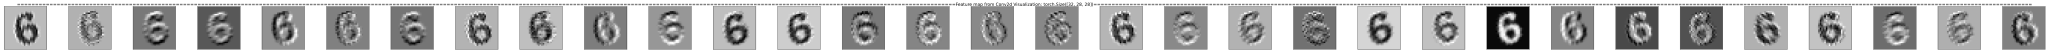

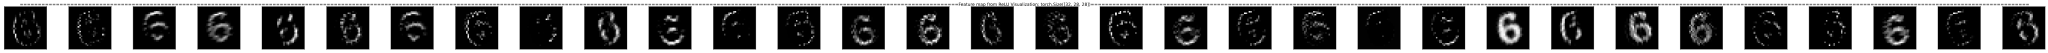

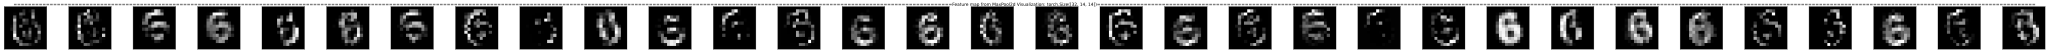

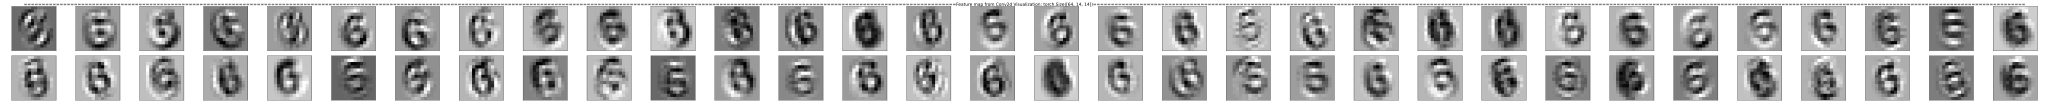

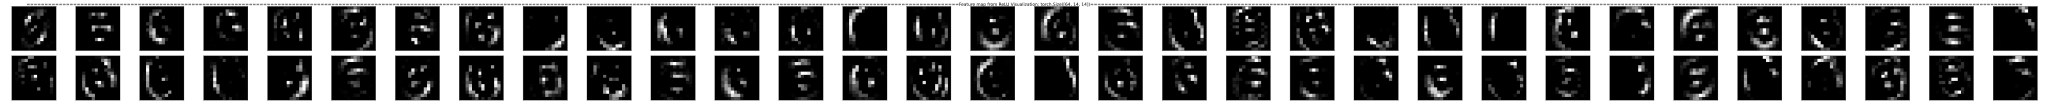

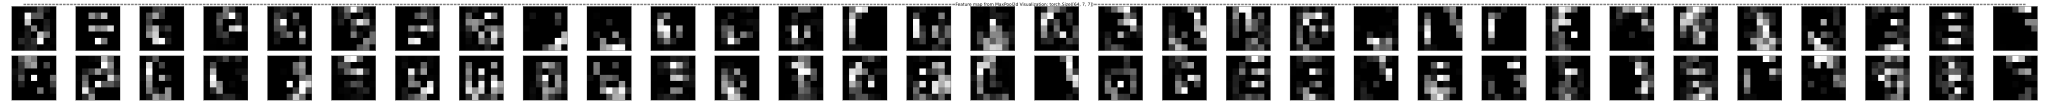

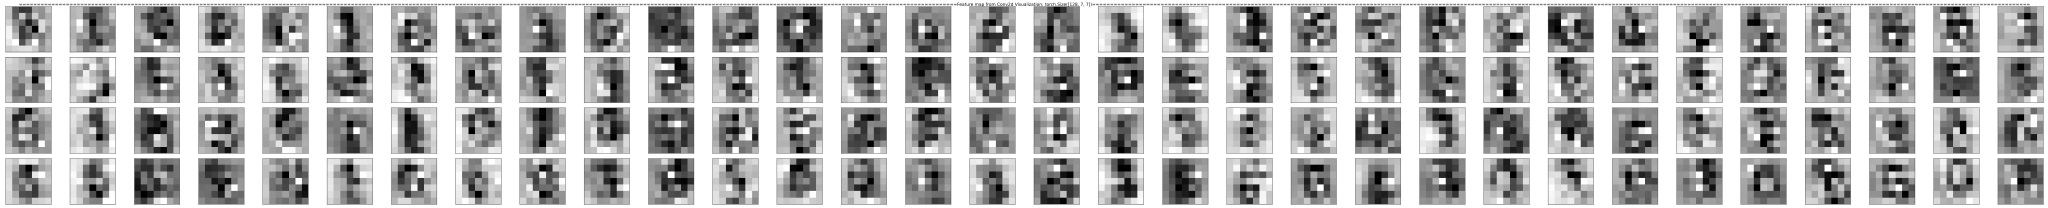

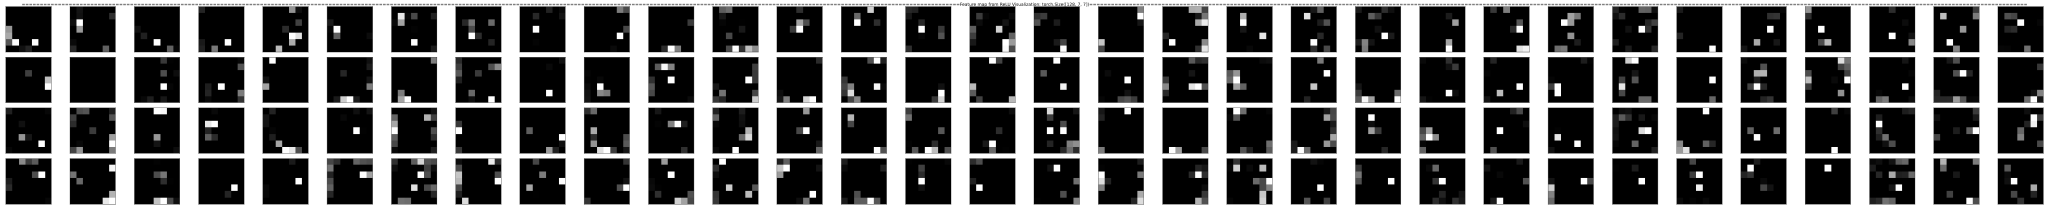

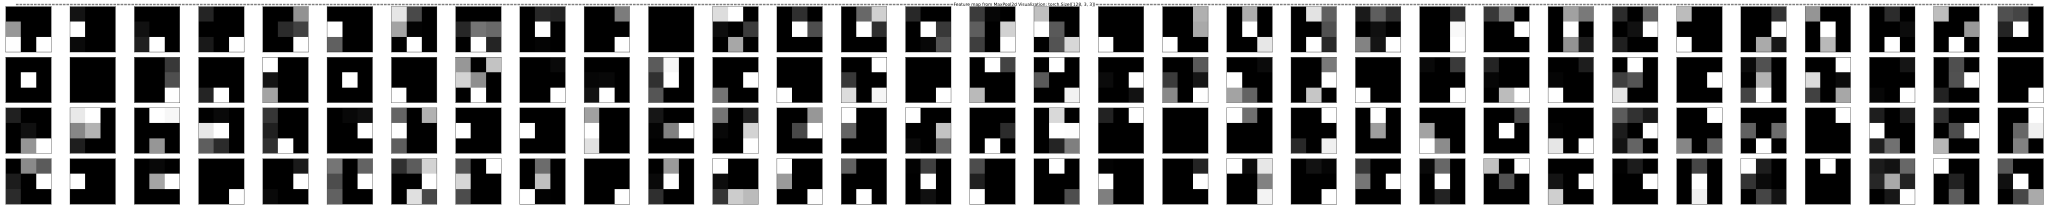

In [ ]:
def visualize_conv_output_layers(feature_maps, layer_name):
  number_of_filters = feature_maps.shape[0]

  number_of_rows = math.ceil(number_of_filters / 32)
  number_of_columns = 32

  plt.figure(figsize = (80, number_of_rows * 2))
  border_in_string = "=" * 260
  plt.suptitle(f"{border_in_string}Feature map from {layer_name} Visualization: {feature_maps.shape}{border_in_string}", y = 1)
  for index, feature_map in enumerate(feature_maps):
    plt.subplot(number_of_rows, number_of_columns, index + 1, label = f"Feature Map {index}")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_map.cpu(), cmap = "gray")

  plt.tight_layout()
  plt.show()

def forward_propagate_layers(sample_datum, flattened_model_layers, device):
  all_layers_output = []
  with torch.no_grad():
    output = sample_datum
    for layer in flattened_model_layers:
      output = output.to(device)
      output = layer(output)
      all_layers_output.append(output)
      print(f"Layer: {layer}, with output size: {output.shape}")
  return all_layers_output

def flatten_layers_from_model(model):
  # Get all the model layers, except Sequential Layer, 
  # since we'd like to iterate the layers one by one.
  model_layers = list(model.modules())[1:]
  flattened_model_layers = []

  # Filter layers, as we don't want to process sequential layers.
  for index, module in enumerate(model_layers):
    if type(module) != torch.nn.modules.container.Sequential:
      flattened_model_layers.append(module)

  return flattened_model_layers

ocr_model_flattened_layers = flatten_layers_from_model(ocr_tmnist_model)
ocr_model_all_layer_outputs = forward_propagate_layers(sample_datum, ocr_model_flattened_layers, device)

MAX_CONV_LAYERS = 9
ocr_model_conv_layers = ocr_model_flattened_layers[:MAX_CONV_LAYERS]
ocr_model_conv_layer_outputs = ocr_model_all_layer_outputs[:MAX_CONV_LAYERS] # Get only convolution layers output.

for layer_name, layer_output in zip(ocr_model_conv_layers, ocr_model_conv_layer_outputs):
  layer_output = torch.sum(layer_output, dim = 0)
  layer_name = str(layer_name).split("(")[0]
  visualize_conv_output_layers(layer_output, layer_name)

### With Pytorch Lightning

In this notebook, we use data modelling by using Pytorch Lightning. Pytorch Lightning makes us easier to make Deep Learning Model with modular approach.

![Pytorch Lightning Image](https://pl-bolts-doc-images.s3.us-east-2.amazonaws.com/mov.gif)

Make the model.

In [ ]:
class OCR_MNISTClassifierModel(pl.LightningModule):
    def __init__(self, batch_size, learning_rate, trainset, valset):
        super().__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.trainset = trainset
        self.valset = valset

        # We calculate this formula for padding.
        # NOTES: Filter_size = kernel_size
        # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

        # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
        # Output after conv1: [(28 - 3 + 2 (1) / 1) + 1] = 28
        # Output after MaxPool1 = 28 / 2 = 14
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), nn.ReLU(), nn.MaxPool2d(2,2))

        # To attain same padding: we use features of 
        # Padding: [(3 - 1) / 2] = 1
        # Output after conv2: [(14 - 3 + 2 (1) / 1) + 1] = 14
        # Output after MaxPool2: 14 / 2 = 7
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), nn.ReLU(), nn.MaxPool2d(2,2))

        # Flatten the layers.
        # 32 = number of filters
        # 7 = size of max pool 2 feature map output.
        self.fc1 = nn.Sequential(nn.Flatten(), nn.Linear(64*7*7,32), nn.ReLU(), nn.Linear(32,16), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(16,32), nn.ReLU(), nn.Linear(32,64), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(64,94))

    def train_dataloader(self):
      # transforms
      return torch.utils.data.DataLoader(
        self.trainset, 
        batch_size = self.batch_size, 
        shuffle = True,
      )

    def val_dataloader(self):
      return torch.utils.data.DataLoader(
          self.valset,
          batch_size = self.batch_size,
          shuffle = False,
      )

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        return {'loss': loss, 'log': self.log}

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr = self.learning_rate, momentum = 0.8)

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.softmax(x, dim = 1)
        return x

In [ ]:
ocr_tmnist_classifier_model = OCR_MNISTClassifierModel(
    batch_size = 64,
    learning_rate = 0.001,
    trainset = tmnist_train_dataset,
    valset = tmnist_validation_dataset
)

trainer = pl.Trainer(auto_scale_batch_size = False, auto_lr_find = True, gpus = 0)

trainer.tune(ocr_tmnist_classifier_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.8317637711026709
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_22fadfb6-9794-454f-abf2-e88296746b31.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_22fadfb6-9794-454f-abf2-e88296746b31.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f9a744a8df0>}

#### Visualize the learning rate Plot.

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_02ef9174-ccc3-4ca8-98c8-7f30f94f7b71.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_02ef9174-ccc3-4ca8-98c8-7f30f94f7b71.ckpt


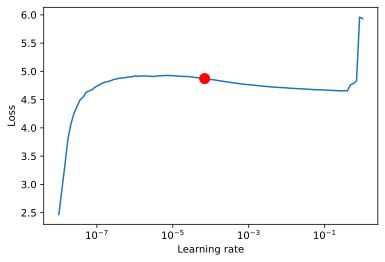

In [ ]:
lr_finder = trainer.tuner.lr_find(ocr_tmnist_classifier_model)

# Plot learning rate finder.
fig = lr_finder.plot(suggest=True)
fig.show()

Fit the model to the data

In [ ]:
trainer.fit(ocr_mnist_classifier_model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 320   
1 | conv2 | Sequential | 18.5 K
2 | fc1   | Sequential | 100 K 
3 | fc2   | Sequential | 2.7 K 
4 | fc3   | Sequential | 6.1 K 
-------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.514     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

## MAIN EVENT: Performing OCR.

After an exhaustive process, it's time to bring the model to the test to detect OCR!

#### Data Preprocessing

Get sample image.

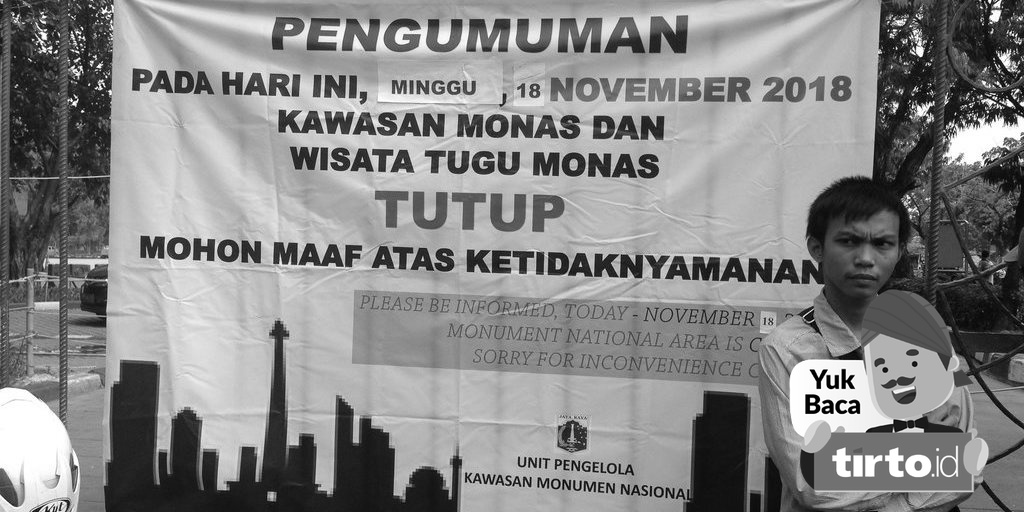

In [ ]:
ocr_dataset_dir = "./drive/MyDrive/Dataset/OCR"
sample_poster_image_path = f"{ocr_dataset_dir}/pengumuman_2.jpg"

# 0 = read in grayscale
sample_poster_image = cv2.imread(sample_poster_image_path, 0) 
cv2_imshow(sample_poster_image)

Performing Histogram Equalization.

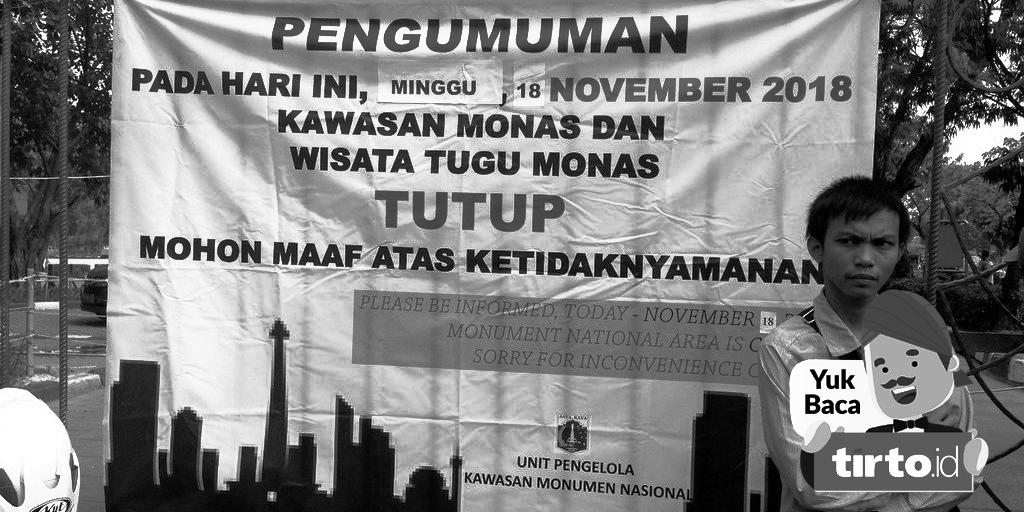

In [ ]:
equalized_sample_image = cv2.equalizeHist(sample_poster_image)
cv2_imshow(equalized_sample_image)

Perform Blurring

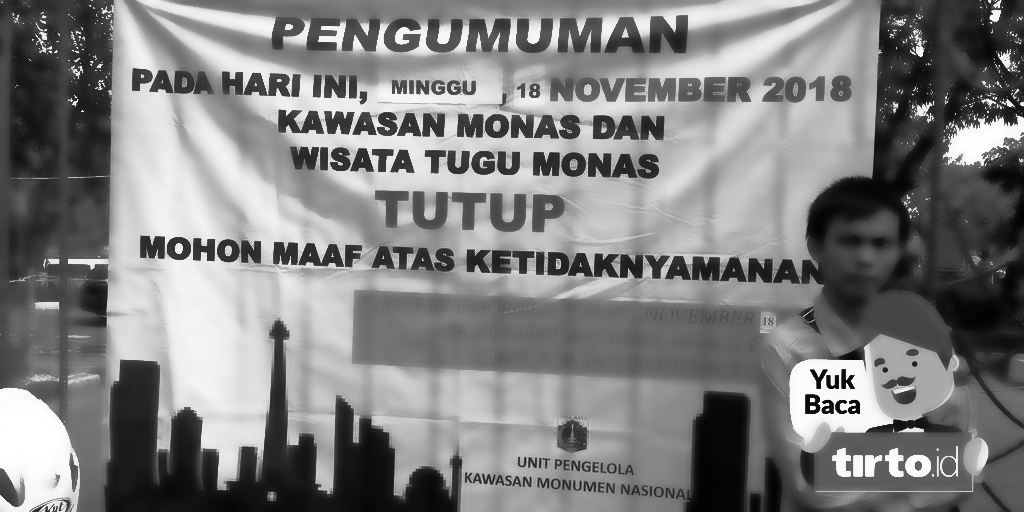

In [ ]:
blurred_image = cv2.bilateralFilter(equalized_sample_image, 15, 55, 45)
cv2_imshow(blurred_image)

Perform Adaptive Thresholding

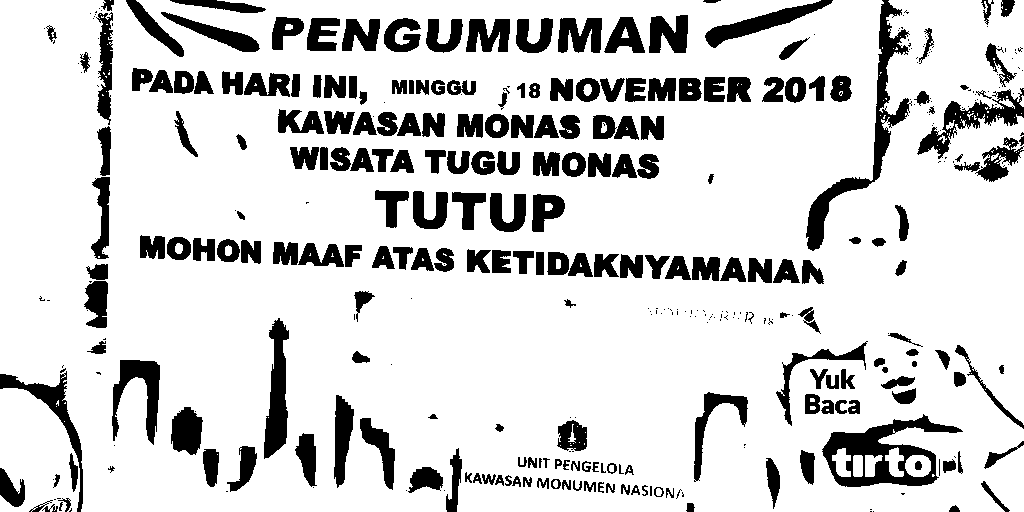

In [ ]:
adaptive_averaged_sample_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 79, 29)
cv2_imshow(adaptive_averaged_sample_image)

Perform Color Invert

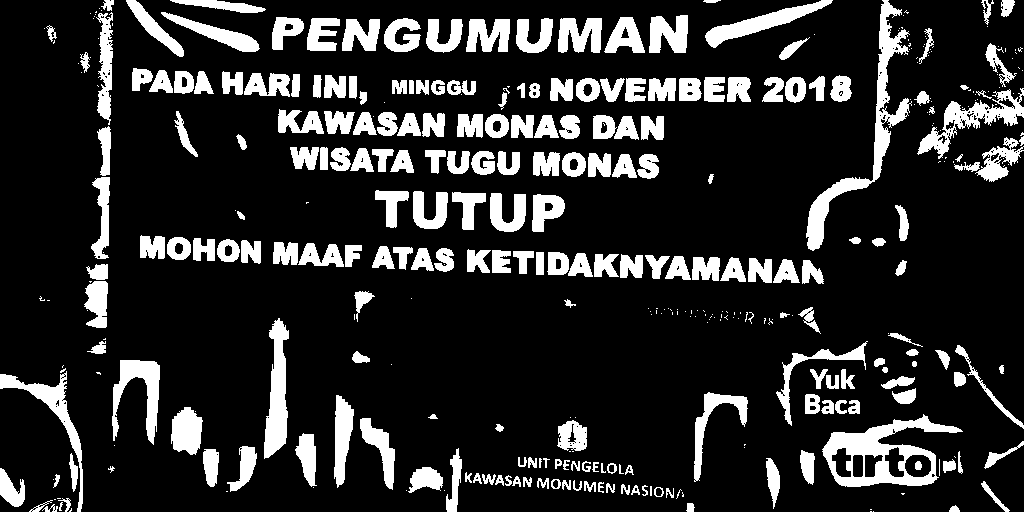

In [ ]:
inverted_sample_image = 255 - adaptive_averaged_sample_image
cv2_imshow(inverted_sample_image)

#### Get Region of Interests

Copy latest preprocessed image.

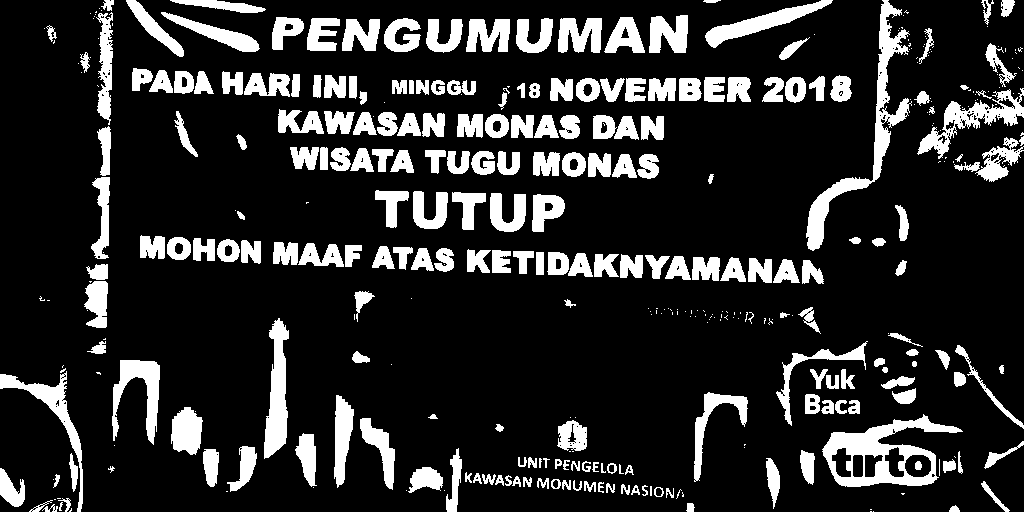

In [ ]:
preprocessed_sample_image = inverted_sample_image.copy()
cv2_imshow(preprocessed_sample_image)

Canny Edge Detection to detect contours.

In [ ]:
# canny_sample_image = cv2.Canny(preprocessed_sample_image, 40, 150)
# cv2_imshow(canny_sample_image)

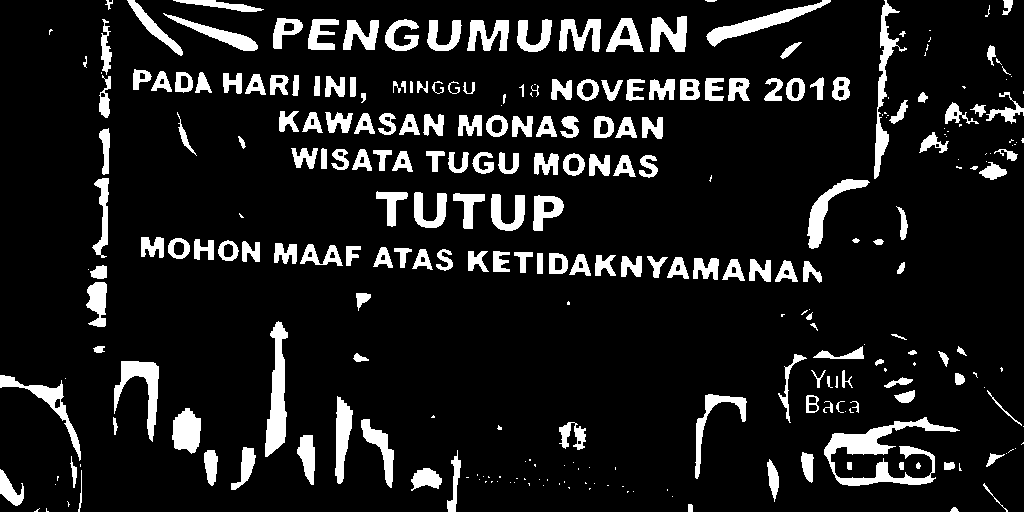

In [ ]:
eroded_sample_image = cv2.erode(preprocessed_sample_image, np.ones((3, 3)))
cv2_imshow(eroded_sample_image)

In [ ]:
def find_text_contours(image, method = "left-to-right"):
  """
  Returns the position of the texts, from the contour given.
  """
  # RETR_EXTERNAL: Only getting the external contour.
  # CHAIN_APPROX_SIMPLE = Just get the simple contour information.
  contours = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  contours = sort_contours(contours, method = method)[0]
  return contours

text_contours = find_text_contours(eroded_sample_image)
text_contours

(array([[[  0, 469]],
 
        [[  0, 493]],
 
        [[  1, 493]],
 
        [[  8, 500]],
 
        [[  9, 500]],
 
        [[ 13, 504]],
 
        [[ 14, 504]],
 
        [[ 15, 505]],
 
        [[ 17, 505]],
 
        [[ 18, 504]],
 
        [[ 19, 504]],
 
        [[ 21, 502]],
 
        [[ 21, 501]],
 
        [[ 22, 500]],
 
        [[ 22, 499]],
 
        [[ 23, 498]],
 
        [[ 23, 486]],
 
        [[ 22, 485]],
 
        [[ 22, 483]],
 
        [[ 21, 483]],
 
        [[ 22, 484]],
 
        [[ 22, 488]],
 
        [[ 21, 489]],
 
        [[ 21, 493]],
 
        [[ 19, 495]],
 
        [[ 17, 495]],
 
        [[ 16, 494]],
 
        [[ 16, 493]],
 
        [[ 14, 491]],
 
        [[ 14, 490]],
 
        [[ 12, 488]],
 
        [[ 12, 487]],
 
        [[ 11, 486]],
 
        [[ 11, 484]],
 
        [[  9, 482]],
 
        [[  9, 481]],
 
        [[  8, 480]],
 
        [[  8, 479]],
 
        [[  6, 477]],
 
        [[  6, 476]],
 
        [[  5, 475]],
 
        [[  5, 4

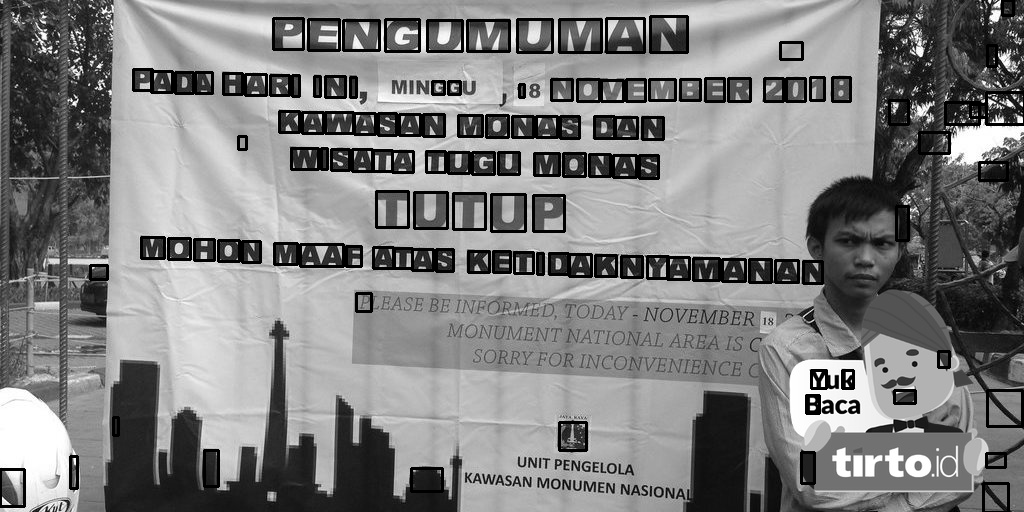

In [ ]:
def get_bounding_box_from_contours(contours, min_width, max_width, min_height, max_height):
  accepted_contours = []

  for contour in contours:
    # From the coordinates (position) given from contours, get the bounding box.
    (x, y, width, height) = cv2.boundingRect(contour)

    if (width >= min_width and width <= max_width) and \
      (height >= min_height and height <= max_height):
      
      bounding_box = (x, y, width, height)
      accepted_contours.append(bounding_box)

  return accepted_contours

contour_bounding_boxes = get_bounding_box_from_contours(text_contours, 5, 45, 13, 37)

sample_poster_image_with_bb = sample_poster_image.copy()

region_of_interest_images = []

for bounding_box in contour_bounding_boxes:
  x, y, width, height = bounding_box
  region_of_interest_images.append(eroded_sample_image[y:y+height, x:x+width])
  #  cv2.rectangle(contour_bounding_boxes)
  #  cv2_imshow(region_of_interest_image)
  cv2.rectangle(
      sample_poster_image_with_bb, 
      (x, y), 
      (x + width, y + height), 
      (0, 0, 255), 
      2,
  )

cv2_imshow(sample_poster_image_with_bb)

#### Pass region of interests to the model

Visualize ROI Images.

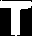

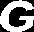

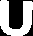

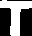

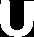

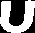

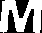

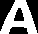

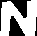

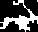

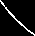

In [ ]:
for image in region_of_interest_images:
  cv2_imshow(image)

Resize region of interest image, so it can be passed to the model. Recall that the size of the input model is 28 * 28.

In [ ]:
resized_roi_images = []

def get_proportionally_resized_image(image, desired_height, desired_width):
  # Apply transformation, which will make the image proportion to the image.
  if height > width:
    resized_image = imutils.resize(image, height = desired_height)
  else:
    resized_image = imutils.resize(image, width = desired_width)
  
  # Apply subtraction, so we can apply padding to it.
  expand_x_size = (desired_width - width) 
  expand_y_size = (desired_height - height) 

  # Apply padding with black color.
  # By the way, we divide the subtraction with 2, since we apply to 2 directions:
  # e.g. (left and right), (top and bottom)
  # So, the character can stay at the center of the image.
  dimension_x = int(max(0, expand_x_size) / 2.0)
  dimension_y = int(max(0, expand_y_size) / 2.0)

  # Finally, apply the border.
  filled_resized_image = cv2.copyMakeBorder(
      resized_image, 
      top = dimension_y, 
      bottom = dimension_y, 
      right = dimension_x, 
      left = dimension_x,
      borderType=cv2.BORDER_CONSTANT, value = (0,0,0)
  )

  filled_resized_image = cv2.resize(filled_resized_image, (28, 28))
  return filled_resized_image

for image in region_of_interest_images:
  filled_resized_roi_image = get_proportionally_resized_image(image, 28, 28)

  # Apply transformed image. 
  resized_roi_images.append(filled_resized_roi_image)

for roi_image in resized_roi_images:
  cv2_imshow(roi_image)

#### Feed the data to the model and apply transformations.

Preprocess the ROI Images.

torch.Size([1, 1, 28, 28])


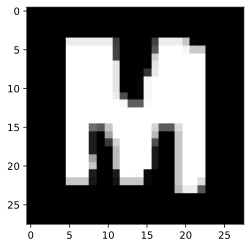

In [ ]:
sampl_roi_image = resized_roi_images[5]

tensor_roi_sample_image = torch.Tensor(sampl_roi_image)
# tensor_roi_sample_image = tensor_roi_sample_image.unsqueeze(0)

sample_roi_image_transform_func = transforms.Lambda(tmnist_validation_transform)
tensor_roi_sample_image = sample_roi_image_transform_func(tensor_roi_sample_image)
tensor_roi_sample_image = tensor_roi_sample_image.unsqueeze(0)
print(tensor_roi_sample_image.shape)

plt.imshow(tensor_roi_sample_image.squeeze(0).squeeze(0), cmap = "gray")

Feed forward to the model.

In [ ]:
def feed_forward_model(model, datum, device):
  model = model.to(device)
  datum = datum.to(device)

  outputs = model(datum)
  return outputs

def get_highest_value(values):
  return torch.argmax(values)

output = feed_forward_model(ocr_tmnist_model, tensor_roi_sample_image, device)
prediction_index = get_highest_value(output).cpu().numpy()

character_prediction = full_labels[prediction_index]
print(character_prediction)

M


Repeat the steps above, but with all characters.

126


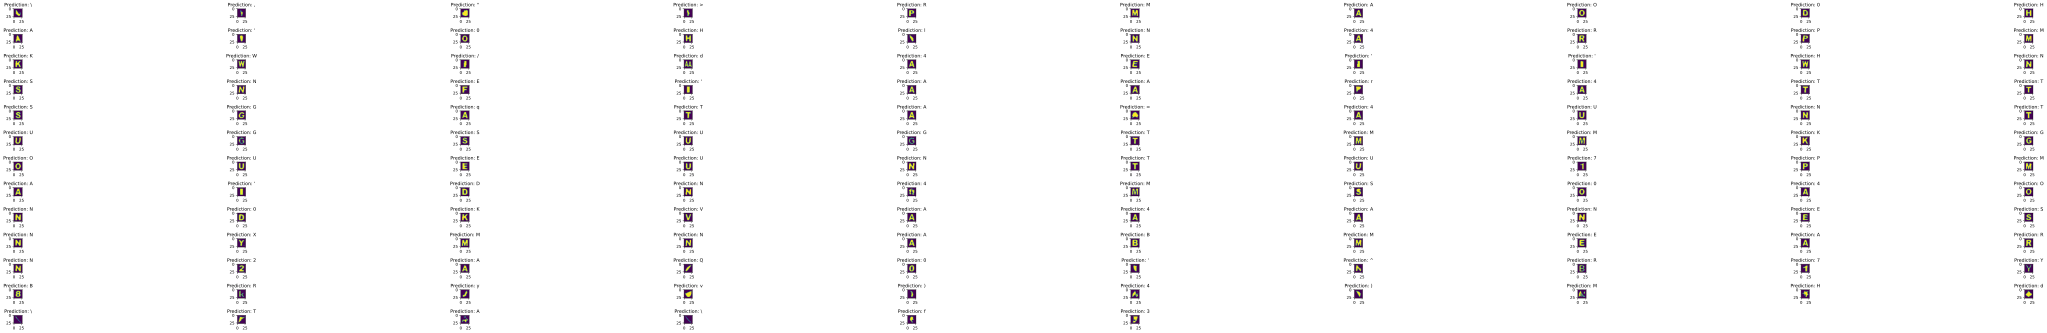

In [ ]:
def simple_pytorch_ocr(model, image, transform_func, device):
  tensor_roi_sample_image = torch.Tensor(image)

  sample_roi_image_transform_func = transforms.Lambda(tmnist_validation_transform)
  tensor_roi_sample_image = transform_func(tensor_roi_sample_image)
  tensor_roi_sample_image = tensor_roi_sample_image.unsqueeze(0)

  prediction = feed_forward_model(model, tensor_roi_sample_image, device)

  return prediction

print(len(resized_roi_images))

plt.figure(figsize = (80, 20))

for index, roi_image in enumerate(resized_roi_images):
  plt.subplot(int(len(resized_roi_images) / 10) + 10, 10, index + 1)

  predictions = simple_pytorch_ocr(
      ocr_tmnist_model, 
      roi_image, 
      transforms.Lambda(tmnist_validation_transform),
      device
  )

  prediction_index = get_highest_value(predictions).cpu().numpy()

  character_prediction = full_labels[prediction_index]
  plt.title(f"Prediction: {character_prediction}")
  plt.imshow(roi_image)

plt.tight_layout()
plt.show()

#### Putting it all together

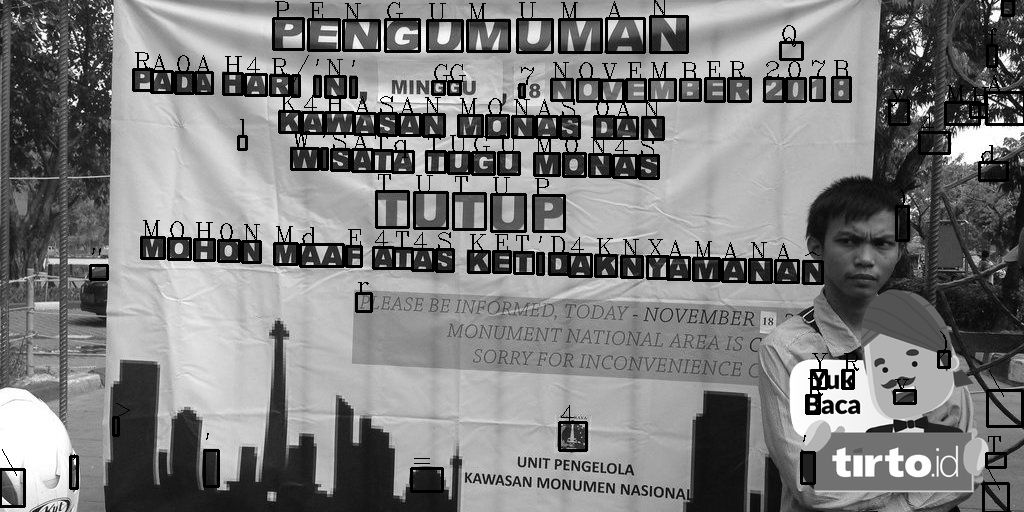

In [ ]:
# Get bounding box from contours.
region_of_interest_images = []

# Get region of interests from contours.
# We get the preprocessed image before thresholding!
contour_bounding_boxes = get_bounding_box_from_contours(text_contours, 5, 45, 13, 37)
for bounding_box in contour_bounding_boxes:
  x, y, width, height = bounding_box
  region_of_interest_images.append(eroded_sample_image[y:y+height, x:x+width])
  
# Proportionally Resize ROI Images.
resized_roi_images = []
for image in region_of_interest_images:
  filled_resized_roi_image = get_proportionally_resized_image(image, 28, 28)
  resized_roi_images.append(filled_resized_roi_image)

# Perform OCR to predict the characters.
character_predictions = []
for index, roi_image in enumerate(resized_roi_images):
  prediction_index = simple_pytorch_ocr(
      ocr_tmnist_model,
      roi_image,
      transforms.Lambda(tmnist_validation_transform),
      device
  )

  prediction_index = get_highest_value(prediction_index).cpu().numpy()

  character_prediction = full_labels[prediction_index]
  character_predictions.append(character_prediction)

# Display the OCR result into the sample image.
sample_poster_image_with_bb = sample_poster_image.copy()
for character, bounding_box in zip(character_predictions, contour_bounding_boxes):
  x, y, width, height = bounding_box

  cv2.rectangle(
      sample_poster_image_with_bb, 
      (x, y), 
      (x + width, y + height), 
      (0, 0, 255), 
      2,
  )

  cv2.putText(sample_poster_image_with_bb, character, (x, y), cv2.FONT_HERSHEY_COMPLEX , 0.8, (0, 0, 0),)

cv2_imshow(sample_poster_image_with_bb)

## Evaluation using Top N Accuracy.

This is because some uppercase and lowercase letters almost have the same shape (e.g. Z and z). This can make deep learning models hard to distinguish the difference. Thus, we loosened the accuracy a little bit, so the model still can get good performance.